In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

LOADING TEST DATA AND TRAIN DATA

In [2]:
test_data = scipy.io.loadmat("C:\\Users\\ankan\\Desktop\\PCA\\test_set.mat")
train_data = scipy.io.loadmat("C:\\Users\\ankan\\Desktop\\PCA\\train_set.mat")

Checking the data for shape and categories they are stored as

In [3]:
print(scipy.io.whosmat('C:\\Users\\ankan\\Desktop\\PCA\\train_set.mat'))
print(scipy.io.whosmat('C:\\Users\\ankan\\Desktop\\PCA\\test_set.mat'))

[('data', (320, 10304), 'uint8'), ('labels', (1, 320), 'int32')]
[('data', (80, 10304), 'uint8'), ('labels', (1, 80), 'int32')]


GPU availability check

In [4]:
devices = tf.config.list_physical_devices('GPU')
for device in devices:
    print(device)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Mean Centering the data

In [5]:
def mean_centre(data):
  #Find mean of each column
  mean_vector= np.mean(data, axis=0).reshape(1,data.shape[1])
  one_vector=np.ones((data.shape[0],1))
  #mean_vector=[mu1 mu2 mu3...]^T shape is dx1 one_vector=[1 1 1...]^T shape is =nx1. This matrix multiplication  is done to get n rows of mean_vector so that each sample can be mean centred
  centred_data=data-np.matmul(one_vector,mean_vector)
  return centred_data

Eigen Vector Calculation

In [6]:
def eigen_vector(X):
  #Getting eigen values and eigen vectors
  eigvals, eigvecs = np.linalg.eig(np.matmul(np.transpose(X),X)/X.shape[0])
  #Normalizing eigen vectors
  sum_squared = (eigvecs**2).sum(axis=0)
  sqrt_sum = np.sqrt(sum_squared)
  eigvecs=eigvecs/sqrt_sum
  return [eigvals,eigvecs]    
    

Arranging eigen vectors corresponding to highest eigen value to lowest eigen value

In [7]:
def top_k_eigen_vector(eig,k):
  eigvals,eigvecs=eig
  eigvals_desc = np.sort(eigvals, kind='quicksort')[::-1]
  #Arranging eigen vectors with respect to largest to smallest eigenvalues
  eigvecs_desc=np.empty((eigvecs.shape[0],0))
  for i in range(k):
    for j in range(len(eigvals)):
        if(eigvals[j]==eigvals_desc[i]):
          eigvecs_desc=np.append(eigvecs_desc,eigvecs[:,j].reshape(eigvecs.shape[0],1),axis=1)
  return eigvecs_desc

Choosing first image of each label to visualize

In [8]:
def visualize(X,y):
  labels =y
  unique_labels = np.unique(labels)  # {0, 1}

  indices = []
  for label in unique_labels:
    index = np.where(labels == label)[0][0]
    indices.append(index)
  c=0
  fig, axs =plt.subplots(5,8)
  for i in range (5):
    for j in range(8):
      img=X[indices[c]].reshape(112,92)
      axs[i, j].text(0.5, -0.15, str(y[indices[c]]), transform=axs[i,j].transAxes,horizontalalignment='center', verticalalignment='center')
      c=c+1
      axs[i,j].imshow(img,cmap='gray')
  for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])   
  plt.show()
  return

Choosing top k eigen vectors based on the eigen vectors that can capture 95% of the total variance in data


In [9]:
def variance(eigvec):
  variances = np.var(eigvec, axis=0)
  lambda_d=np.sum(variances)
  for i in range (len(variances)):
    lambda_k=np.sum(variances[:i+1])
    if (lambda_k/lambda_d>=0.95):
      break
  return i

Y=XP where X is the data matrix P is the Priciple Components(top k egen vectors)and Y is the transformed matrix to nXk dim

In [10]:
def k_dim_rep(X,eigvecs):
  Y=np.matmul(X,eigvecs)
  return Y

Mean Square Error calculation

In [11]:
def mean_square_error(z,X):
  error=(z-X)
  mse=np.diag(np.matmul(error,np.transpose(error)))
  return mse



Mean Centering Data

In [12]:
train_centred=mean_centre(train_data['data'])
print(train_centred.shape)


(320, 10304)


In [13]:
test_centred=mean_centre(test_data['data'])

All eigen values and eigenvectors are stored as eig

In [14]:

with tf.device('/GPU:0'):
    eig=eigen_vector(train_centred)


Only taking the real parts of the eigenvectors

In [15]:
eigvals,eigvecs=eig
eigvecs=np.real(eigvecs)
eig=[eigvals,eigvecs]

In [16]:
with tf.device('/GPU:0'):
    eigvectors=top_k_eigen_vector(eig,train_centred.shape[1])

Top k eigenvectors required to capture 95% of the variance is:

In [17]:
k=variance(eigvectors)

Here d is the total number of eigenvectors/total number of original dimensions=10304

In [18]:
print(k)

9196


Train Data visualization of one of each label:

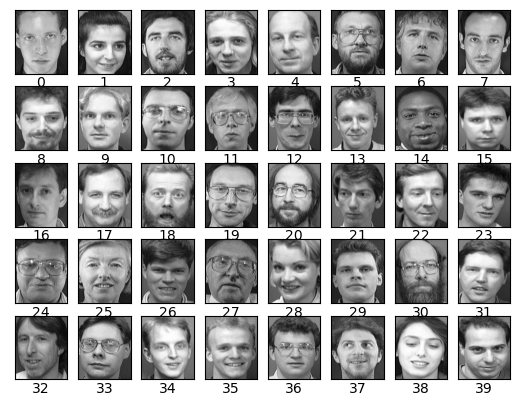

In [19]:
y=train_data['labels'].reshape(train_data['labels'].shape[1],)
X=train_data['data']
visualize(X,y)

Test Data visualization of one of each label:

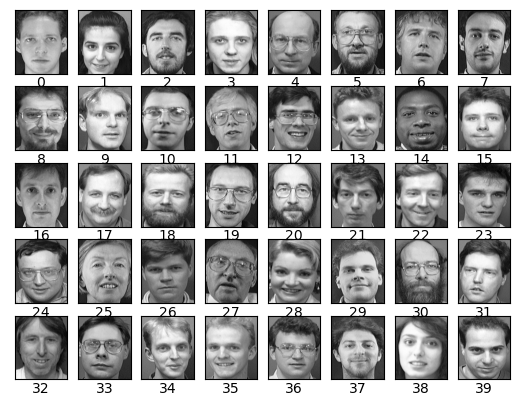

In [20]:
y_true=test_data['labels'].reshape(test_data['labels'].shape[1],)
X=test_data['data']
visualize(X,y_true)

Mean Centered Train Data visualization of one of each label:

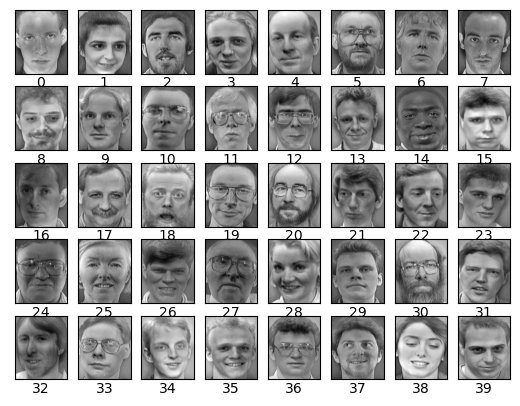

In [21]:
y=train_data['labels'].reshape(train_data['labels'].shape[1],)
X=train_centred
visualize(X,y)

Mean Centered Test Data visualization of one of each label:

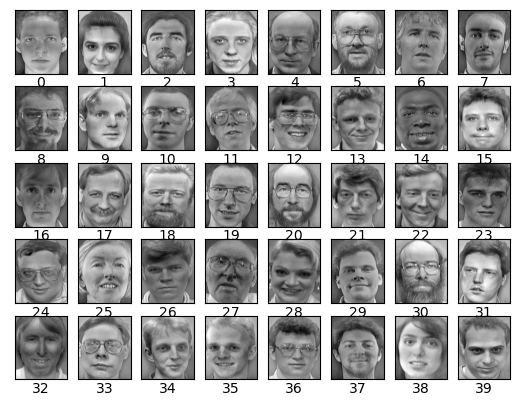

In [22]:
y=test_data['labels'].reshape(test_data['labels'].shape[1],)
X=test_centred
visualize(X,y)

Eigenfaces plot for top 25 eigenvalues

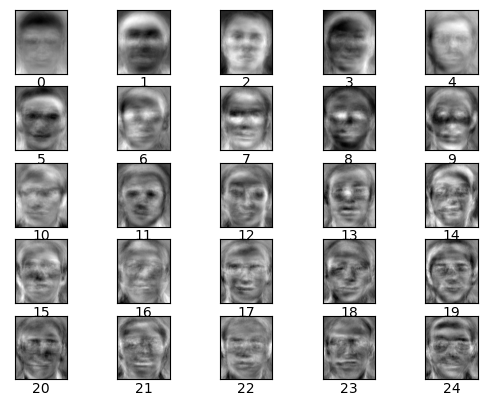

In [23]:
c=0
fig, axs =plt.subplots(5,5)
for i in range (5):
  for j in range(5):
    img=eigvectors[:,c].reshape(112,92)
    axs[i, j].text(0.5, -0.15, str(c), transform=axs[i,j].transAxes,horizontalalignment='center', verticalalignment='center')
    c=c+1
    axs[i,j].imshow(img,cmap='gray')
for ax in axs.flat:
  ax.set_xticks([])
  ax.set_yticks([])   
plt.show()

The eigent vectors from 0 to 24 th label shows the eigenface or features that are most responsible for variations to the least responsibl eigenface for variations.A new face image can be projected onto the space spanned by the eigenfaces and represented as a linear combination of the eigenfaces

In [24]:
eigen_vectors_top_k=(eigvectors[:,:k])

Getting the true image from the reconstructed data of k dimensional representation of data.

(320, 10304)


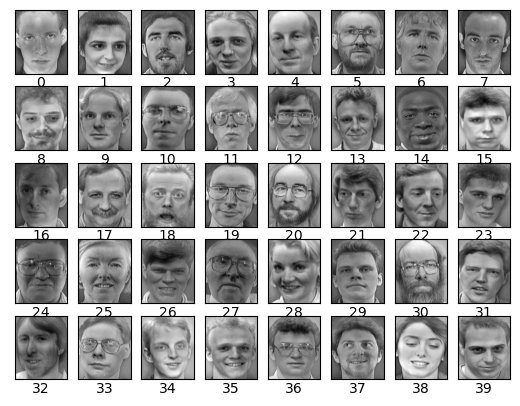

In [25]:

X_new=np.matmul(k_dim_rep(train_centred,eigen_vectors_top_k),np.transpose(eigen_vectors_top_k))
print(X_new.shape)
y=train_data['labels'].reshape(train_data['labels'].shape[1],)
visualize(X_new,y)

Getting k dimensional representation of test data and training data

In [26]:
with tf.device('/GPU:0'):
    z=k_dim_rep(test_centred,eigen_vectors_top_k)
    x_k=k_dim_rep(train_centred,eigen_vectors_top_k)

In [27]:
z.shape
Z= np.tile(z[0],(320,1))


Finding the best match to test data in train data having min ||zi-zT||^2

In [28]:
x_test_match=np.empty((0,train_centred.shape[1]))
y=train_data['labels'].reshape(train_data['labels'].shape[1],)
y_test_match=[]
for i in range (z.shape[0]):
  Z= np.tile(z[i,:],(x_k.shape[0],1))
  mse=mean_square_error(Z,x_k)
  index=np.where(mse==np.amin(mse))[0][0]
  x_test_match=np.append(x_test_match,train_centred[index,:].reshape(1,train_centred.shape[1]),axis=0)
  y_test_match.append(y[index])


Confusion matrix of predicted label corresponding to true label

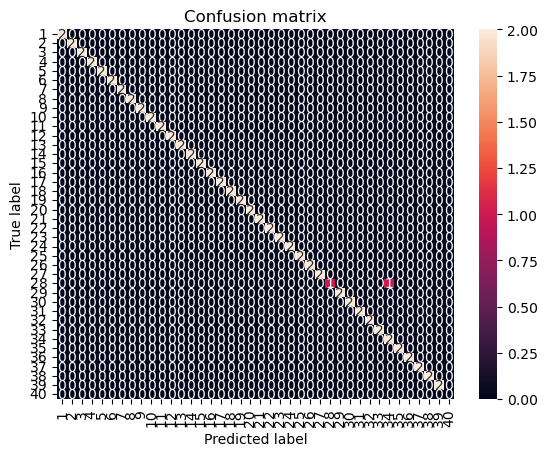

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
labels = range(1, 41)
cm = confusion_matrix(y_true, y_test_match, labels=range(1, 41))

sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)

# Set plot title and axis labels
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Show plot
plt.show()

One blip in prediction can be viewed here where Predicted label=34 whereas, true label=28

Visualization of Train data corresponding to the test data with labels

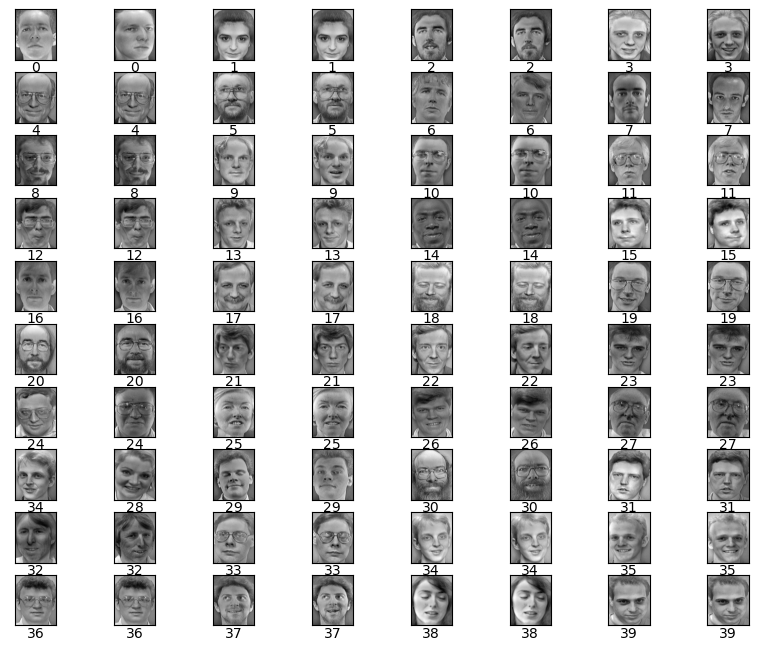

In [30]:
c=0
fig, axs =plt.subplots(10,8,figsize=(10, 8))
for i in range (10):
  for j in range(8):
    img=x_test_match[c,:].reshape(112,92)
    axs[i, j].text(0.5, -0.15, str(y_test_match[c]), transform=axs[i,j].transAxes,horizontalalignment='center', verticalalignment='center')
    c=c+1
    axs[i,j].imshow(img,cmap='gray')
for ax in axs.flat:
  ax.set_xticks([])
  ax.set_yticks([])  
fig.subplots_adjust(hspace=0.25) 
plt.show()

Here we can see 34th label in training data is matched with test data in 7th row 1st column.

Visualization of Test data with labels

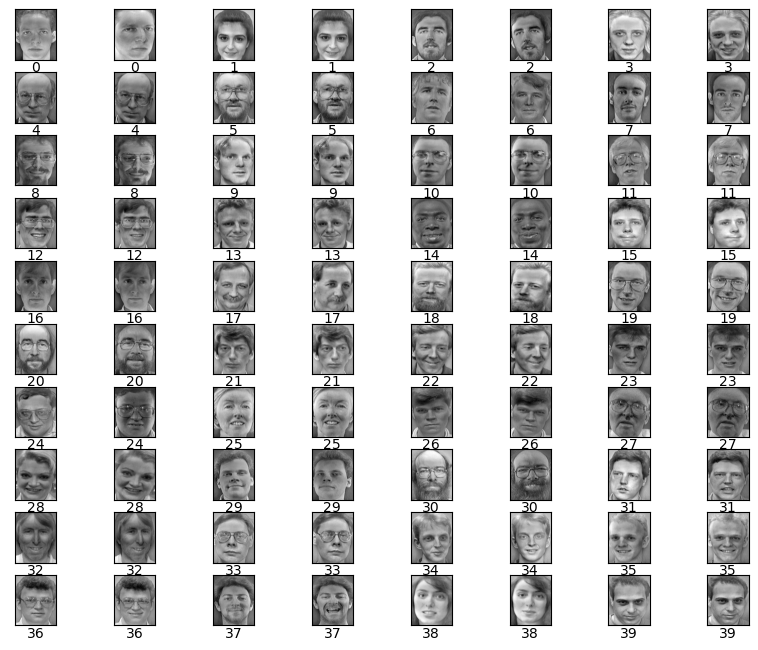

In [31]:
c=0
fig, axs =plt.subplots(10,8,figsize=(10, 8))
for i in range (10):
  for j in range(8):
    img=test_centred[c,:].reshape(112,92)
    axs[i, j].text(0.5, -0.15, str(y_true[c]), transform=axs[i,j].transAxes,horizontalalignment='center', verticalalignment='center')
    c=c+1
    axs[i,j].imshow(img,cmap='gray')
for ax in axs.flat:
  ax.set_xticks([])
  ax.set_yticks([])  
fig.subplots_adjust(hspace=0.25) 
plt.show()

Here we can see that the true test label in 7th row 1st column is 28 And the images do not even match. So there is one complete error in the model.

Below is the visualization of the test data with the predicted labels

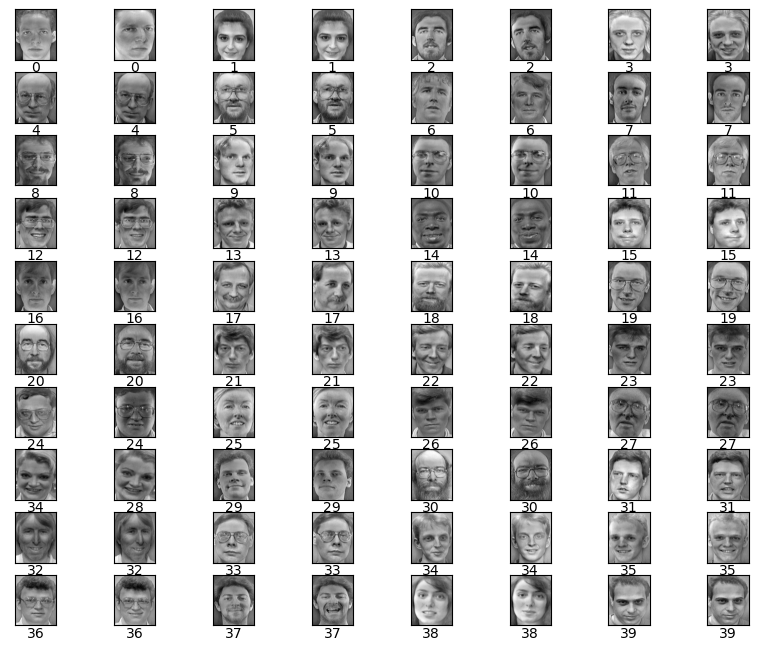

In [32]:
c=0
fig, axs =plt.subplots(10,8,figsize=(10, 8))
for i in range (10):
  for j in range(8):
    img=test_centred[c,:].reshape(112,92)
    axs[i, j].text(0.5, -0.15, str(y_test_match[c]), transform=axs[i,j].transAxes,horizontalalignment='center', verticalalignment='center')
    c=c+1
    axs[i,j].imshow(img,cmap='gray')
for ax in axs.flat:
  ax.set_xticks([])
  ax.set_yticks([])  
fig.subplots_adjust(hspace=0.25) 
plt.show()

Accuracy of predicted label with true labels

In [33]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_test_match)

# Print accuracy
print("Accuracy:", accuracy)

Accuracy: 0.9875


Taking Eigen Vectors less than k(that captures 95% of the variance in data):

In [34]:
eigen_vectors_top_k=(eigvectors[:,:10])

In [35]:
with tf.device('/GPU:0'):
    z=k_dim_rep(test_centred,eigen_vectors_top_k)
    x_k=k_dim_rep(train_centred,eigen_vectors_top_k)

In [36]:
x_test_match=np.empty((0,train_centred.shape[1]))
y=train_data['labels'].reshape(train_data['labels'].shape[1],)
y_test_match=[]
for i in range (z.shape[0]):
  Z= np.tile(z[i,:],(x_k.shape[0],1))
  mse=mean_square_error(Z,x_k)
  index=np.where(mse==np.amin(mse))[0][0]
  x_test_match=np.append(x_test_match,train_centred[index,:].reshape(1,train_centred.shape[1]),axis=0)
  y_test_match.append(y[index])


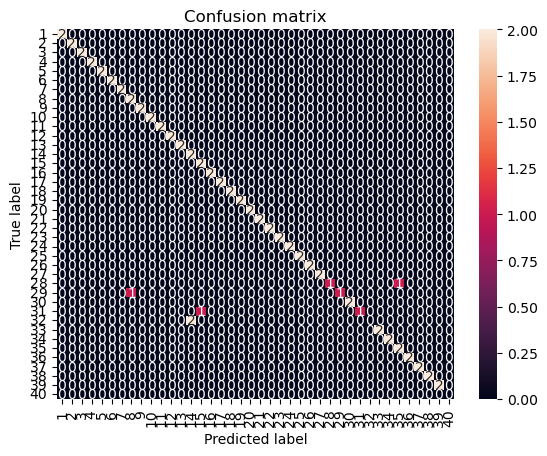

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
labels = range(1, 41)
cm = confusion_matrix(y_true, y_test_match, labels=range(1, 41))

sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)

# Set plot title and axis labels
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Show plot
plt.show()

We can see that the number of errors has increased significantly after taking k=10.

In [38]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_test_match)

# Print accuracy
print("Accuracy:", accuracy)

Accuracy: 0.925


Taking Eigen Vectors greater than k(that captures 95% of the variance in data):

In [39]:
eigen_vectors_top_k=(eigvectors[:,:10304])

In [40]:
with tf.device('/GPU:0'):
    z=k_dim_rep(test_centred,eigen_vectors_top_k)
    x_k=k_dim_rep(train_centred,eigen_vectors_top_k)

In [41]:
x_test_match=np.empty((0,train_centred.shape[1]))
y=train_data['labels'].reshape(train_data['labels'].shape[1],)
y_test_match=[]
for i in range (z.shape[0]):
  Z= np.tile(z[i,:],(x_k.shape[0],1))
  mse=mean_square_error(Z,x_k)
  index=np.where(mse==np.amin(mse))[0][0]
  x_test_match=np.append(x_test_match,train_centred[index,:].reshape(1,train_centred.shape[1]),axis=0)
  y_test_match.append(y[index])


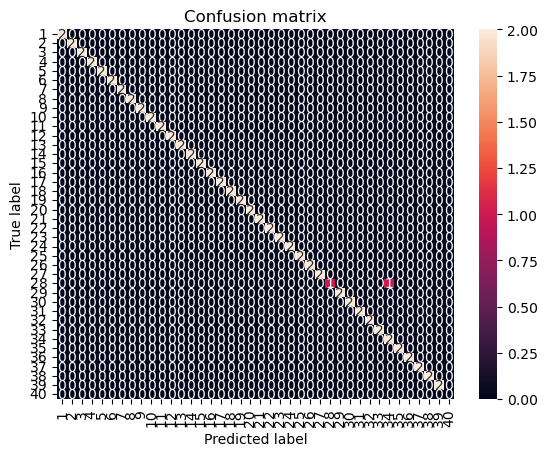

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
labels = range(1, 41)
cm = confusion_matrix(y_true, y_test_match, labels=range(1, 41))

sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)

# Set plot title and axis labels
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Show plot
plt.show()

In [43]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_test_match)

# Print accuracy
print("Accuracy:", accuracy)

Accuracy: 0.9875


Even after taking the maximum number of principle components accuracy doesn't go beyond 98.75%